**Andere manier om te kijken naar evaluation, i.p.v terug te splitten en te predicten, nu opgeslagen predicition gebruiken**

In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn.functional as F
import os
import json  # Needed for loading the mappings

# === Define path to the saved run ===
save_path = r"C:\Users\corne\OneDrive - KU Leuven\Thesis\Working Code\SAVED-Models\GroNLP\Run_2025-04-23_18-28"

# ✅ Load the saved test predictions 
df = pd.read_csv(os.path.join(save_path, "test_predictions.csv"))

# ✅ Recreate logits tensor from the CSV
logits = torch.tensor(df["logits"].apply(eval).tolist())

# ✅ Apply softmax to get prediction probabilities
probabilities = F.softmax(logits, dim=1)

# ✅ Extract raw values
texts = df["text"].tolist()
true_labels_ids = df["true_label"].tolist()
predicted_label_ids = df["predicted_label"].tolist()

# ✅ Convert label IDs to themes using the mappings
with open(os.path.join(save_path, "label_mappings.json"), "r", encoding="utf-8") as f:
    mappings = json.load(f)

theme_to_id = mappings["theme_to_id"]
id_to_theme = {int(k): v for k, v in mappings["id_to_theme"].items()}  # convert keys back to int
unique_themes = mappings["unique_themes"]  # Load the unique themes list


**Unknowns**

In [11]:
# ✅ Predict labels without "Unknown" filtering
predicted_labels = []
for i in range(len(probabilities)):
    pred_id = torch.argmax(probabilities[i]).item()
    predicted_labels.append(id_to_theme[pred_id])

# ✅ Convert true labels to theme names
true_labels = [id_to_theme[i] for i in true_labels_ids]

# ✅ Compare and mark correctness
results = []
for true, pred in zip(true_labels, predicted_labels):
    if true == pred:
        results.append("Correct")
    else:
        results.append("Incorrect")

# ✅ Build output DataFrame
output_df = pd.DataFrame({
    "Text": texts,
    "True_Theme": true_labels,
    "Predicted_Theme": predicted_labels,
    "Result": results
})

# ✅ Save it
# ✅ Save it as an Excel file
output_df.to_excel("evaluated_predictions.xlsx", index=False)


In [4]:
unknown_count = predicted_labels.count("Unknown")
print(f"Unknown predictions: {unknown_count} / {len(predicted_labels)} ({unknown_count/len(predicted_labels)*100:.2f}%)")


Unknown predictions: 0 / 9686 (0.00%)


**Evaluations**

C:\Users\corne\AppData\Local\Temp\ipykernel_14292\2092822640.py:42: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


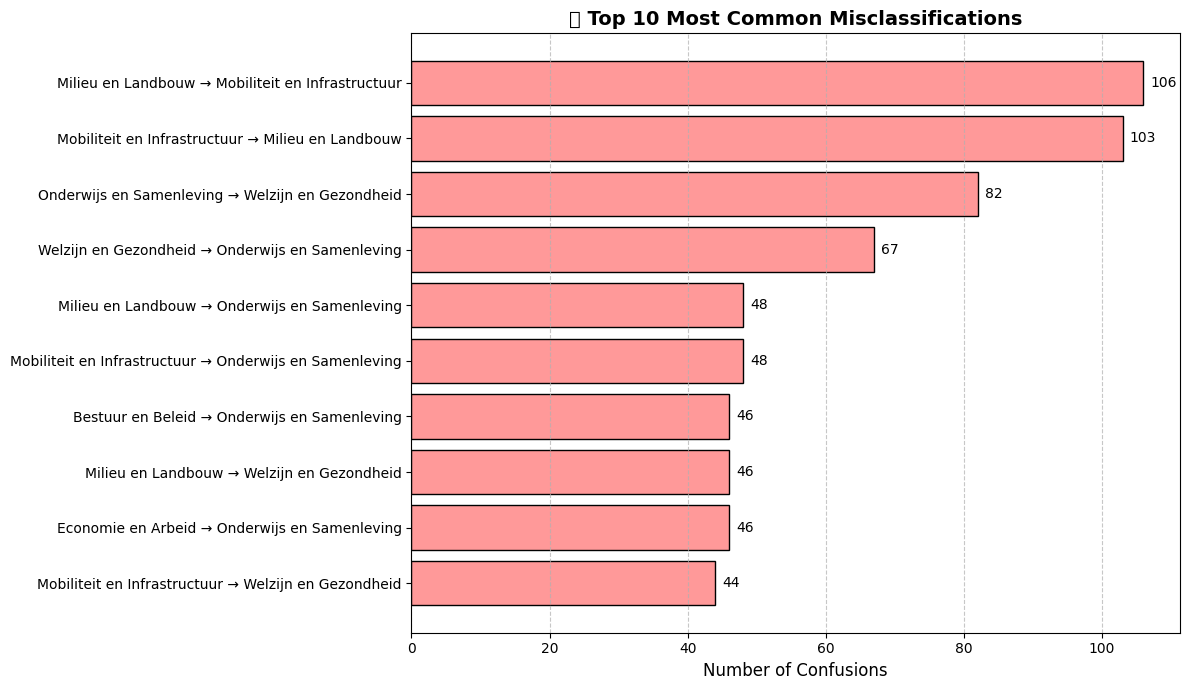

In [24]:

# ✅ Misclassification analysis (excluding Unknowns)
df_misclassified = output_df[
    (output_df["Result"] == "Incorrect")
]

top_confusions = (
    df_misclassified
    .groupby(["True_Theme", "Predicted_Theme"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

# ✅ Convert MultiIndex to string for plotting
top_confusions_plot = top_confusions.copy()
top_confusions_plot.index = [f"{true} → {pred}" for true, pred in top_confusions_plot.index]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
bars = plt.barh(
    top_confusions_plot.index,
    top_confusions_plot.values,
    color="#ff9999",
    edgecolor="black"
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=10)


# Styling
plt.xlabel("Number of Confusions", fontsize=12)
plt.title("🔍 Top 10 Most Common Misclassifications", fontsize=14, weight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



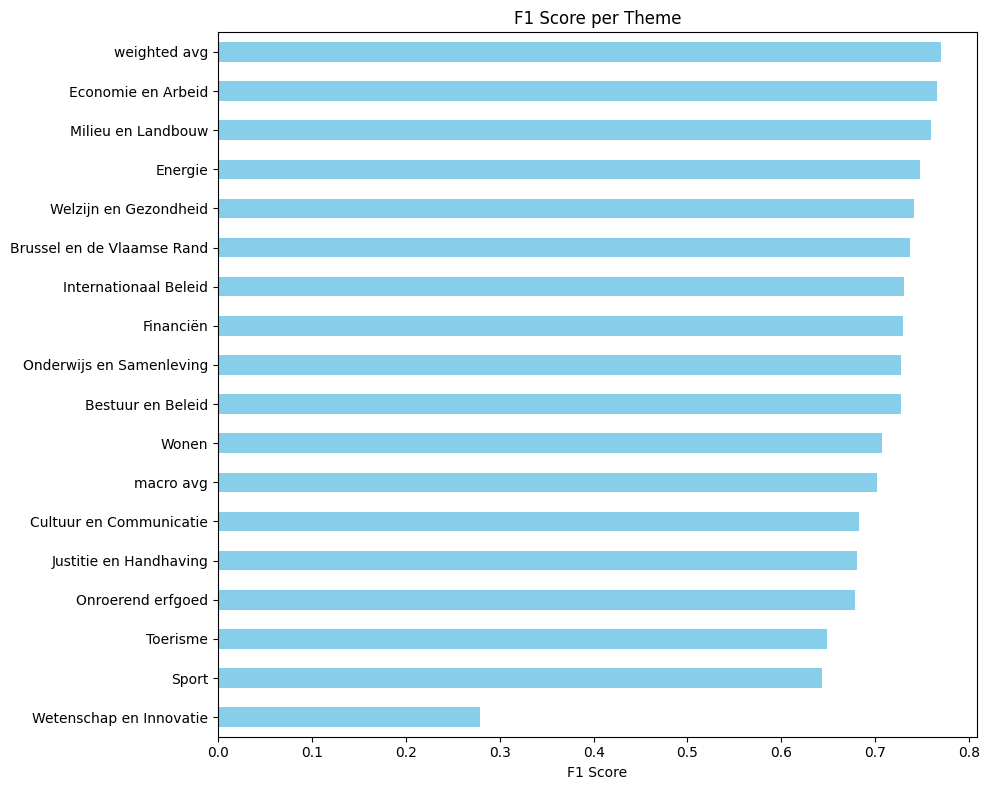

In [7]:
# for clean per-class evaluation, you want to exclude "Unknown" from both True and Predicted values:

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# ✅ Encode using only the matching rows
le = LabelEncoder()
true_encoded = le.fit_transform(output_df["True_Theme"])
pred_encoded = le.transform(output_df["Predicted_Theme"])

# ✅ Get classification report
report = classification_report(
    true_encoded,
    pred_encoded,
    target_names=le.classes_,
    output_dict=True
)

# ✅ Visualize F1 per class
import pandas as pd
import matplotlib.pyplot as plt

df_report = pd.DataFrame(report).transpose().sort_values("f1-score")
df_report[:-3]["f1-score"].plot(kind="barh", figsize=(10, 8), color="skyblue")
plt.title("F1 Score per Theme")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()

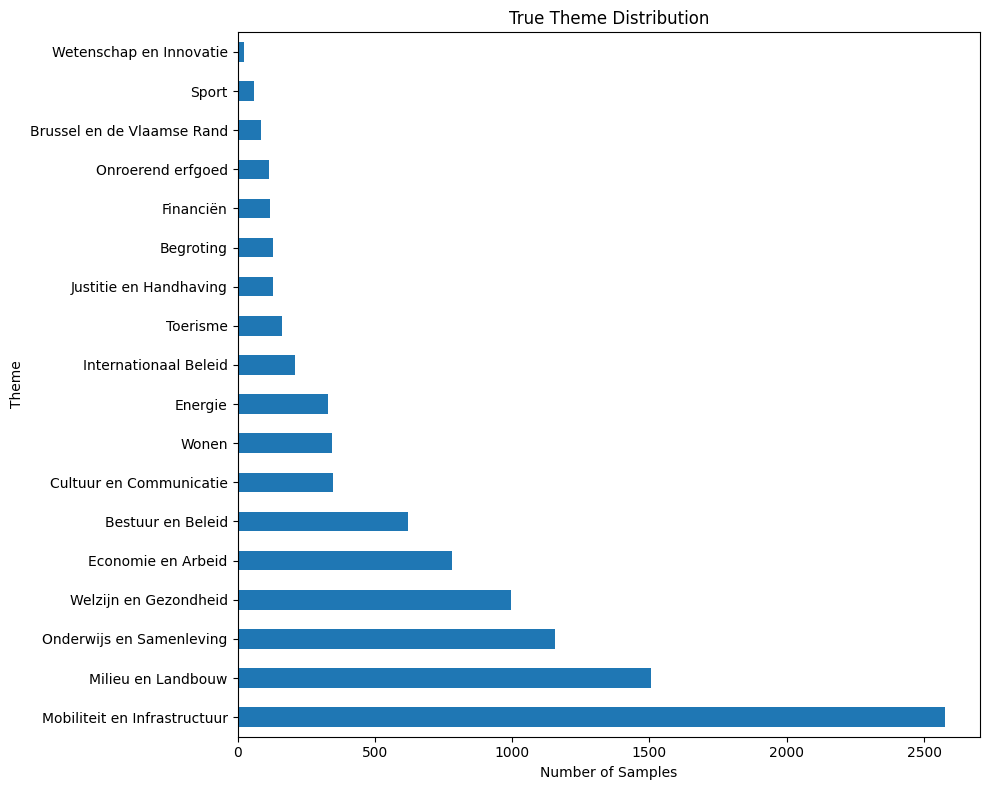

In [8]:
output_df["True_Theme"].value_counts().plot(kind="barh", figsize=(10, 8))

plt.title("True Theme Distribution")
plt.xlabel("Number of Samples")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import classification_report

# Filter out "Unknown"
filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

# Get all unique themes used
all_labels = sorted(set(filtered_true + filtered_pred))

# ✅ Print classification report using theme names directly
print(classification_report(
    filtered_true,
    filtered_pred,
    labels=all_labels,
    target_names=all_labels,
    zero_division=0
))


                              precision    recall  f1-score   support

                   Begroting       0.79      0.75      0.77       128
           Bestuur en Beleid       0.74      0.71      0.73       621
  Brussel en de Vlaamse Rand       0.82      0.67      0.74        84
     Cultuur en Communicatie       0.72      0.65      0.68       349
          Economie en Arbeid       0.77      0.76      0.77       780
                     Energie       0.78      0.72      0.75       331
                   Financiën       0.73      0.73      0.73       117
       Internationaal Beleid       0.81      0.67      0.73       210
      Justitie en Handhaving       0.71      0.65      0.68       129
          Milieu en Landbouw       0.75      0.77      0.76      1505
Mobiliteit en Infrastructuur       0.86      0.88      0.87      2575
    Onderwijs en Samenleving       0.70      0.75      0.73      1157
           Onroerend erfgoed       0.70      0.66      0.68       114
                   

In [10]:
# ✅ Compute metrics (excluding "Unknown")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

accuracy = accuracy_score(filtered_true, filtered_pred)
precision = precision_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
recall = recall_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
f1 = f1_score(filtered_true, filtered_pred, average="weighted", zero_division=0)

print("\n📊 Evaluation (excluding 'Unknown'):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


📊 Evaluation (excluding 'Unknown'):
Accuracy:  0.7704
Precision: 0.7702
Recall:    0.7704
F1-Score:  0.7697


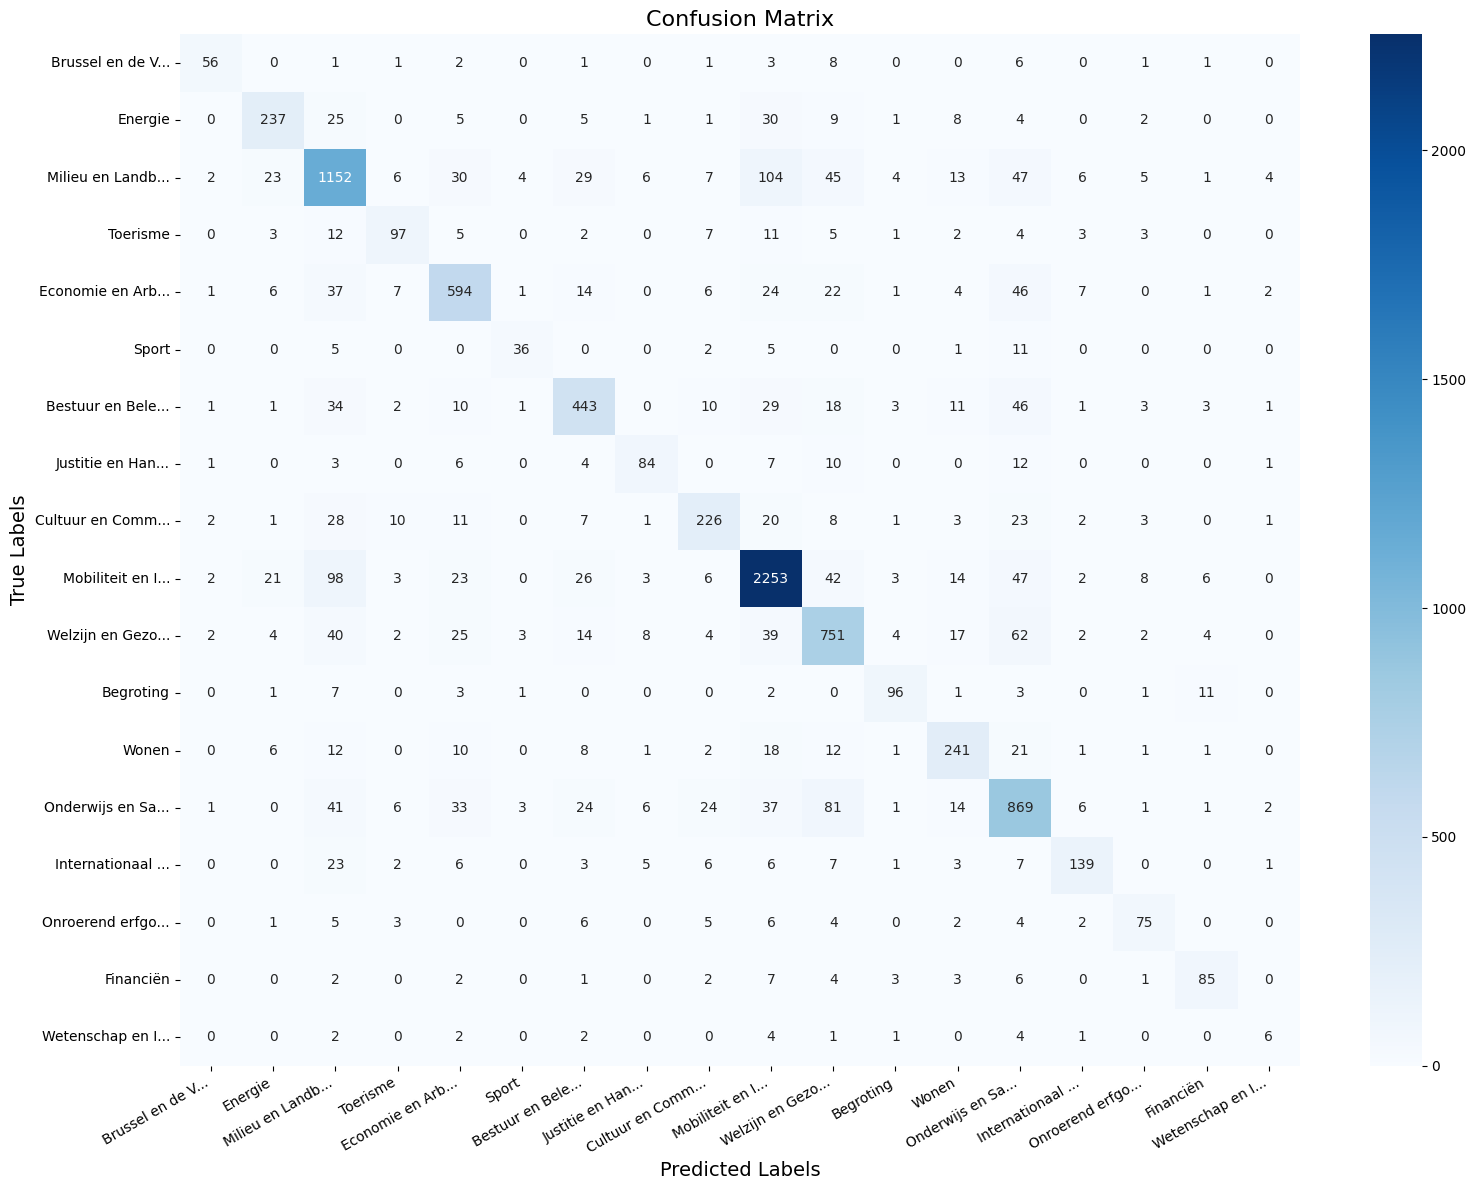

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_themes)

# Shorten labels for better readability (optional)
short_labels = [label[:15] + "..." if len(label) > 15 else label for label in unique_themes]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=short_labels, yticklabels=short_labels, cbar=True)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=30, ha="right", fontsize=10)  # Rotate x-axis labels slightly
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = r"C:\Users\corne\OneDrive - KU Leuven\Thesis\Working Code\SAVED-Models\final\Dataset3\robBERT3"
model_name = "GroNLP/bert-base-dutch-cased"              # aanpassen naar welk model je wilt evaluaten !!!!
tokenizer = BertTokenizer.from_pretrained(model_name) 
model = BertForSequenceClassification.from_pretrained(model_path).cuda()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at C:\Users\corne\OneDrive - KU Leuven\Thesis\Working Code\SAVED-Models\final\Dataset3\robBERT3 and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
def get_attention_and_prediction(clean_text):
    """Extracts attention scores and model prediction for a given question."""
    model.config.output_attentions = True  # Ensure attention is enabled

    # Tokenize and move to device
    tokenizer_inputs = tokenizer(clean_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    tokenizer_inputs = {key: val.to(device) for key, val in tokenizer_inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**tokenizer_inputs)

    # Extract attention and logits
    attentions = outputs.attentions
    logits = outputs.logits

    # Get predicted class ID and name
    predicted_class_id = logits.argmax(dim=1).item()
    predicted_class_name = id_to_theme.get(predicted_class_id, "Unknown")

    return attentions, predicted_class_id, predicted_class_name


In [12]:
test_question = "Hoeveel subsidies zijn toegekend aan bedrijven?"
attention_scores, predicted_class_id, predicted_class_name = get_attention_and_prediction(test_question)

print(f"✅ Model predicted class: {predicted_class_name} (ID: {predicted_class_id})")
print(f"🔍 Total Attention Layers Extracted: {len(attention_scores)}")


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


✅ Model predicted class: Begroting (ID: 11)
🔍 Total Attention Layers Extracted: 12


In [13]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load saved predictions
df = pd.read_csv(r"C:\Users\jefva\Documents\Master\Thesis_s2\Code\BERT_Classifiers\mBERT\output\test_predictions.csv")

# Reconstruct logits and true labels
logits = np.array(df["logits"].apply(eval).tolist())
y_true = np.array(df["true_label"].tolist())
y_score = logits  # raw logits

# Get number of classes
n_classes = y_score.shape[1]

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute support (number of samples per class)
support = np.bincount(y_true, minlength=n_classes)
total = support.sum()

# Compute weighted AUC
weighted_auc = sum(roc_auc[i] * support[i] for i in range(n_classes)) / total
print(f"✅ Weighted ROC AUC: {weighted_auc:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (Weighted AUC = {:.2f})".format(weighted_auc))
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jefva\\Documents\\Master\\Thesis_s2\\Code\\BERT_Classifiers\\mBERT\\output\\test_predictions.csv'

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


# Sample 2000 rows for UMAP
sample_df = df[["text", "true_label"]].sample(n=min(2000, len(df)), random_state=42)
sample_df.rename(columns={"text": "clean_text", "true_label": "theme_id"}, inplace=True)

# Function to get CLS embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.base_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.cpu().squeeze().numpy()

# Generate embeddings
embeddings = []
print("Generating fine-tuned embeddings (from test set)...")
for text in tqdm(sample_df["clean_text"]):
    emb = get_cls_embedding(text)
    embeddings.append(emb)

# Run UMAP
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Encode labels for plotting
le = LabelEncoder()
labels = le.fit_transform(sample_df["theme_id"])

# Plot UMAP
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
plt.title("UMAP of mBERT Embeddings (After Fine-tuning on Test Set)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cb = plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Theme")
tick_labels = [id_to_theme[i] for i in le.classes_]
cb.ax.set_yticklabels(tick_labels)
plt.clim(-0.5, len(le.classes_)-0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

Generating fine-tuned embeddings (from test set)...


100%|██████████| 2000/2000 [00:39<00:00, 50.48it/s]

Running UMAP...


AttributeError: module 'umap' has no attribute 'UMAP'